# Sentiment Analysis: Large Movie Review Dataset

Basically a basic sentiment analysis problem consists of a classification problem, where the possible output labels are: `positive` and `negative`. Which indicates, if the review of a movie speaks positively or negatively. 


Regarding the data, we are going to download the data from [AI Stanford Dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

### These are the objectives of the project:

* Read data that is not in a traditional format.
* Put together a set of preprocessing functions that we can use later on any NLP or related problems.
* Vectorize the data in order to apply a machine learning model to it: using BoW or TF-IDF.
* Train a sentiment analysis model that allows us to detect positive and negative opinions in movie reviews.

---
## 1. Getting the data

#### Download the data and process it in order to obtain:

* `X_train:` list with reviews for training.
* `y_train:` list with labels for training.
* `X_test:` list with reviews for testing.
* `y_test:` list with labels for testing.


In [ ]:
import os

from pathlib import Path
import sys
sys.path.append(str(Path('/home/app/src/text_normalizer.py').parent.parent))
import text_normalizer
from text_normalizer import *

sys.path.append(str(Path('/home/app/src/evaluation.py').parent.parent))
import evaluation
from evaluation import *


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

from nltk.tokenize.toktok import ToktokTokenizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Creating X_train, y_train, X_test and y_test

In [280]:
# Setting the train and test lists

X_train = [] 
y_train = []
X_test =  []
y_test =  []

# TRAIN 
# Loading Positive reviews

# Going trouhg the folder and charging every "txt" in "complete_folders" 
complete_folders=[]
file_path = 'data/train/pos/'
folders = os.listdir(file_path)
for iter_folder in folders:
    complete_folders.append (file_path + iter_folder)

# Creating "X_train" from "complete_folders"
for iter_file in complete_folders:
    f = open (iter_file,'r')
    review = f.read()
    X_train.append (review)
    f.close()

# Loading Negative reviews
complete_folders=[]
file_path = 'data/train/neg/'
folders = os.listdir(file_path)
for iter_folder in folders:
    complete_folders.append (file_path + iter_folder)

for iter_file in complete_folders:
    f = open (iter_file,'r')
    review = f.read()
    X_train.append (review)
    f.close()

# Settig the train labels
half_length= int((len (X_train))/2)
y_train = [ 1 for x in range(half_length)]
y_train[ half_length:(2*half_length)] = [ 0 for x in range(half_length)]

# TEST 
# Loading Positive reviews
complete_folders=[]
file_path = 'data/test/pos/'
folders = os.listdir(file_path)
for iter_folder in folders:
    complete_folders.append (file_path + iter_folder)

for iter_file in complete_folders:
    f = open (iter_file,'r')
    review = f.read()
    X_test.append (review)
    f.close()

# Loading Negative reviews
complete_folders=[]
file_path = 'data/test/neg/'
folders = os.listdir(file_path)
for iter_folder in folders:
    complete_folders.append (file_path + iter_folder)

for iter_file in complete_folders:
    f = open (iter_file,'r')
    review = f.read()
    X_test.append (review)
    f.close()

# Labels
half_length= int((len (X_train))/2)
y_test = [ 1 for x in range(half_length)]
y_test[ half_length:(2*half_length)] = [ 0 for x in range(half_length)]


 

### *Test 1*

In [281]:
def check_data(X_train, y_train, X_test, y_test):
    if len(X_train) == len(y_train) == len(X_test) == len(y_test) == 25000:
        print('Reading Data Success!')
    else:
        raise ValueError('Dimensions do not match!')

check_data(X_train, y_train, X_test, y_test)

Reading Data Success!


---
## 2. Normalizing the data

#### We create `text_normalizer.py` and import them into the notebook 
#### Respect names and minimal interfaces:

* `remove_html_tags(text):` to remove all HTML tags that may be present in text.
* `remove_accented_chars(text):` to remove accented characters from text
* `expand_contractions(text):` to expand contractions of the type, "don't" to "do not". The contractions are already defined in the "contractions.py" file.
* `lemmatize_text(text):` to lemmatize text.
* `stem_text(text):` to apply stemming (NLTK's PorterStemmer) on text.
* `remove_special_chars(text):` to remove special characters from text.
* `remove_special_chars(text, remove_digits=True):` to remove numbers, note that it is the same function to remove special characters with the addition of an argument that enables or disables the removal of numbers.
* `remove_stopwords(text, stopwords=stop_words):` to remove stopwords from text.
* `remove_extra_new_lines(text):` to remove extra newlines from text.
* `remove_extra_whitespace(text):` to remove extra whitespaces from text.



### *Test 2*

We are going to check that the pre-processing does what we need it to do, for this we are going to test the functions with predefined inputs and we are going to see if the outputs match what we are looking for.


In [291]:
import nltk

# Inputs
doc_html = """
<br /><br />But with plague out there and the news being kept a secret,
the New Orleans PD starts a dragnet of the city's underworld.
"""
doc_accented = "Héllo, thís is an accented sénténce."
doc_contractions = "I can't, because it doesn't work."
doc_lemma = "The striped bats are hanging on their feet for best"
doc_stem = """
Where did he learn to dance like that?
His eyes were dancing with humor.
She shook her head and danced away.
"""
doc_specials = "hello? there A-Z-R_T(,**), world, welcome to python. this **should? the next line#followed- by@ an#other %million^ %%like $this."
doc_digits = "abc123def456ghi789zero0 hello my friend number 10"
doc_stop = "He is a very good person"
doc_new_lines = """we
use
a
lot
of
lines"""
doc_spaces = "Hello           my      dear          friend"

# Outputs
good_html = """
But with plague out there and the news being kept a secret,
the New Orleans PD starts a dragnet of the city's underworld.
"""
good_accented = "Hello, this is an accented sentence."
good_contractions = "I cannot, because it does not work."
good_lemma = "the stripe bat be hang on their foot for good"
good_stem = "where did he learn to danc like that ? hi eye were danc with humor. she shook her head and danc away ."
good_specials = "hello there AZRT world welcome to python this should the next linefollowed by another million like this"
good_digits = "abcdefghizero hello my friend number "
good_stop = "good person"
good_new_lines = "we use a lot of lines"
good_spaces = "Hello my dear friend"
stop_words = nltk.corpus.stopwords.words('english')

def check_normalization():
    if good_html == text_normalizer.remove_html_tags(doc_html):
        print('[1/10] Remove HTML Success!')
    else:
        raise ValueError('[1/10] Remove HTML Fail!')
        
    if good_accented == text_normalizer.remove_accented_chars(doc_accented):
        print('[2/10] Remove Accented Success!')
    else:
        raise ValueError('[2/10] Remove Accented Fail!')
        
    if good_contractions == text_normalizer.expand_contractions(doc_contractions):
        print('[3/10] Expand Contractions Success!')
    else:
        raise ValueError('[3/10] Expand Contractions Fail!')
        
    if good_lemma == text_normalizer.lemmatize_text(doc_lemma):
        print('[4/10] Lemmatization Success!')
    else:
        raise ValueError('[4/10] Lemmatization Fail!')
        
    #print(text_normalizer.stem_text(doc_stem))
    if good_stem == text_normalizer.stem_text(doc_stem):
        print('[5/10] Stemming Success!')
    else:
        raise ValueError('[5/10] Stemming Fail!')
        
    if good_specials == text_normalizer.remove_special_chars(doc_specials):
        print('[6/10] Remove Specials Success!')
    else:
        raise ValueError('[6/8] Remove Specials Fail!')
        
    if good_digits == text_normalizer.remove_special_chars(doc_digits, remove_digits=True):
        print('[7/10] Remove Digits Success!')
    else:
        raise ValueError('[7/10] Remove Digits Fail!')
        
    if good_stop == text_normalizer.remove_stopwords(doc_stop, stopwords=stop_words):
        print('[8/10] Remove Stopwords Success!')
    else:
        raise ValueError('[8/10] Remove Stopwords Fail!')
    
    if good_new_lines == text_normalizer.remove_extra_new_lines(doc_new_lines):
        print('[9/10] Remove New Lines Success!')
    else:
        raise ValueError('[9/10] Remove New Lines Fail!')
        
    if good_spaces == text_normalizer.remove_extra_whitespace(doc_spaces):
        print('[10/10] Remove Extra Whitespaces Success!')
    else:
        raise ValueError('[10/10] Remove Extra Whitespaces Fail!')

check_normalization()

[1/10] Remove HTML Success!
[2/10] Remove Accented Success!
[3/10] Expand Contractions Success!
[4/10] Lemmatization Success!
[5/10] Stemming Success!
[6/10] Remove Specials Success!
[7/10] Remove Digits Success!
[8/10] Remove Stopwords Success!
[9/10] Remove New Lines Success!
[10/10] Remove Extra Whitespaces Success!


---
## 3. Feature Engineering

Now we'll vectorize the data.

In [292]:
# Normalization
X_train_norm = X_train_norm_lemmatized
X_test_norm = X_test_norm_lemmatized

# TF - IDF
# Create an instance
vectorizer = TfidfVectorizer(norm = None)

# Generating output for TF_IDF, both for X_train (normalized) and X_test (normalized)
vectorizer.fit(X_train_norm) 
X_train_vect = vectorizer.transform(X_train_norm)
X_test_vect = vectorizer.transform(X_test_norm)


## 4. Modeling and Performance Evaluation

We must train a classification model and we'll show:

* `Precision`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`

To do this we use the `get_performance` function of the `evaluation.py` script.

Also, use the `plot_roc` function so that it can show:

* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`




### Modeling and Evaluation: Strategy

I'll experiment with two classifiers:
    
    * Random Forest

    * LightGBM

Besides, I'll use the two methods for vectorizing:

    * IF-TDF

    * BoW

Finally, I'll use three methods to normalize the corpus:

    * Lemmatization

    * Stemm

    * No Lemma or Stemm (just simple normalization)


So I'll have 6 combinations, which I'll compare in a plot to evaluate the results
     


### 1. RANDOM FOREST CLASSIFIER with TF-IDF

In [293]:
# 1.1 RANDOM FOREST CLASIFFIER with Lemmatization and IF-TDF

### Using RandomizedSearchCV to find the best combination 
### of hyperparameters for a RandomForestClassifier.

rfr= RandomForestClassifier(n_jobs=-1)

# Hyperparameters values of RandomForestClassifier

# Number of trees in the forest
n_estimators = [50,100,500]
# Maximum number of levels in tree
max_depth = [20,50,100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Creating the dictionary of Hyperparameters
hyper_dict = { 'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,}

#Crating an instance of RandomizedSearchCV
#Params:
# n_iter: Number of parameter settings that are sampled. controls how many of combinations of hiperparameters to try
# cv: Determines the cross-validation splitting strategy.

rf_randomCV = RandomizedSearchCV(rfr, hyper_dict,  n_iter=10, cv=5, random_state=124, scoring="roc_auc")
rf_randomCV.fit(X_train_vect, y_train)

# Getting the best parameters for the next experiments
rfr_best_param=rf_randomCV.best_params_
rfr_best_param

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50}

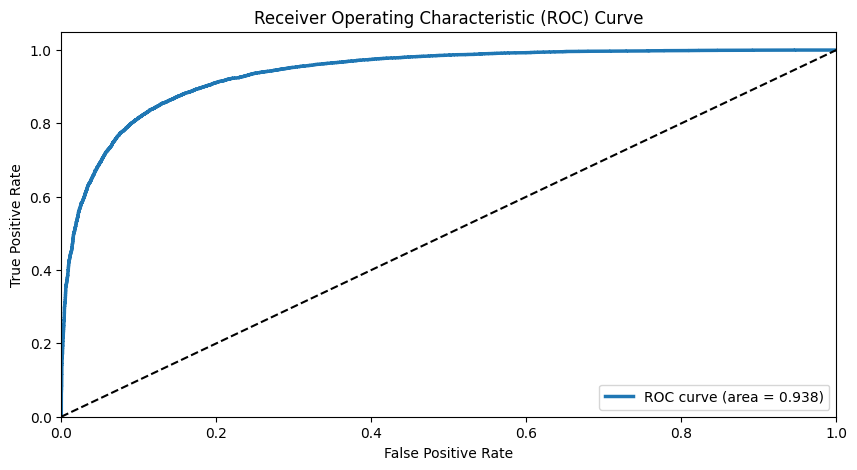

In [294]:
model = rf_randomCV
features = X_test_vect
roc_auc = evaluation.plot_roc(model, y_test, features)

In [295]:
# Saving roc_auc for plot
roc_auc_rf_lemm = roc_auc

### *Don't change anything in this block, just make it run correctly*

Let's check that the `get_performance` function returns the metrics correctly. For that we are going to simulate input/output data of a model.

In [296]:
def check_basic_metrics():
    accuracy, precision, recall, f1_score = evaluation.get_performance(
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0], 
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
    )
    
    if (accuracy, precision, recall, f1_score) == (0.6, 0.6, 0.6, 0.6):
        print('Success!')
    else:
        raise ValueError('You must check your get_performance function!')
        
check_basic_metrics()

Model Performance metrics:
------------------------------
Accuracy: 0.6
Precision: 0.6
Recall: 0.6
F1 Score: 0.6

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.60      0.60      0.60         5
           0       0.60      0.60      0.60         5

    accuracy                           0.60        10
   macro avg       0.60      0.60      0.60        10
weighted avg       0.60      0.60      0.60        10


Prediction Confusion Matrix:
------------------------------
   0  1
0  3  2
1  2  3
Success!


Let's see if your model at least exceeds an ROC-AUC of 0.93

In [297]:
def check_roc(roc_auc):
    if roc_auc > 0.93:
        print('Success!')
    else:
        raise ValueError('Your model is not good enough!')
        
check_roc(roc_auc)

Success!


In [298]:
predict_rf=rf_randomCV.predict(X_test_vect)
evaluation.get_performance(predict_rf, y_test)

Model Performance metrics:
------------------------------
Accuracy: 0.86
Precision: 0.86
Recall: 0.86
F1 Score: 0.86

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.86      0.87      0.86     12500
           0       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10876   1624
1   1834  10666


(0.86, 0.86, 0.86, 0.86)

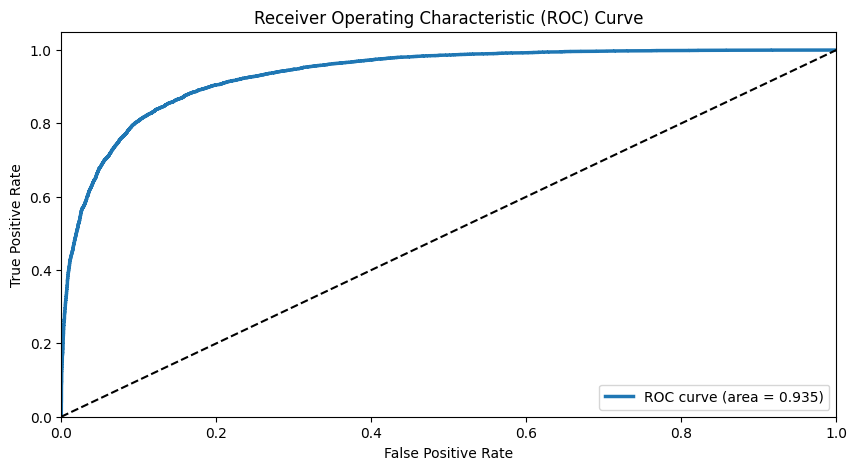

In [299]:
# 1.2 Random Forest with Stemm normalization and TDF-IDF

X_train_norm = X_train_norm_stemm
X_test_norm = X_test_norm_stemm

# TF - IDF
# Create an instance
vectorizer = TfidfVectorizer(norm = None)

# Generating output for TF_IDF, both for X_train and X_test
vectorizer.fit(X_train_norm) 
X_train_vect = vectorizer.transform(X_train_norm)
X_test_vect = vectorizer.transform(X_test_norm)


# RANDOM FOREST CLASIFFIER
rfr= RandomForestClassifier(n_jobs=-1, random_state=0)
rfr.set_params(**rfr_best_param)
rfr.fit(X_train_vect, y_train)

# Predicting and evaluation metrics
model = rfr
features = X_test_vect
roc_auc = evaluation.plot_roc(model, y_test, features)

# Saving roc_auc for plot
roc_auc_rf_stem = roc_auc



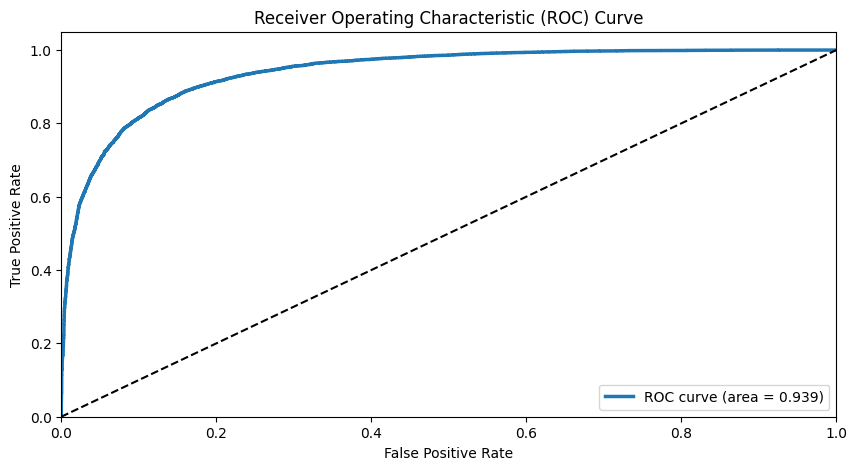

In [300]:
# 1.3 Random Forest without Lemma or Stem normalization and TDF-IDF

X_train_norm = X_train_norm_without
X_test_norm = X_test_norm_without

# TF - IDF
# Create an instance
vectorizer = TfidfVectorizer(norm = None)

# Generating output for TF_IDF, both for X_train and X_test
vectorizer.fit(X_train_norm) 
X_train_vect = vectorizer.transform(X_train_norm)
X_test_vect = vectorizer.transform(X_test_norm)


# RANDOM FOREST CLASIFFIER
rfr= RandomForestClassifier(n_jobs=-1, random_state=0)
rfr.set_params(**rfr_best_param)
rfr.fit(X_train_vect, y_train)

# Predicting and evaluation metrics
model = rfr
features = X_test_vect
roc_auc = evaluation.plot_roc(model, y_test, features)

# Saving roc_auc for plot
roc_auc_rf_without = roc_auc

### 2. RANDOM FOREST CLASSIFIER with BoW

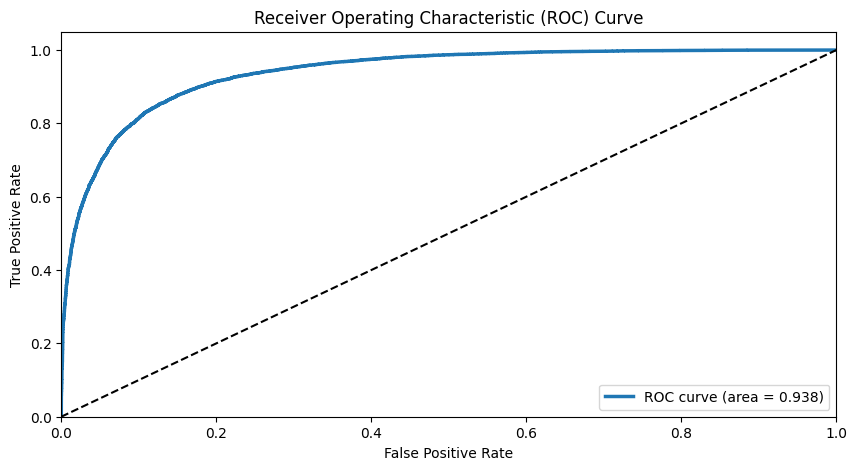

In [301]:
# 2.1 Random Forest with Lemm normalization and Bow

X_train_norm = X_train_norm_lemmatized
X_test_norm = X_test_norm_lemmatized

# BoW
cv = CountVectorizer()                            
cv.fit(X_train_norm)
X_train_vect_bow = cv.transform(X_train_norm)
X_test_vect_bow = cv.transform(X_test_norm)


# RANDOM FOREST CLASIFFIER
rfr= RandomForestClassifier(n_jobs=-1, random_state=0)
rfr.set_params(**rfr_best_param)
rfr.fit(X_train_vect_bow, y_train)

# Predicting and evaluation metrics
model = rfr
features = X_test_vect_bow
roc_auc = evaluation.plot_roc(model, y_test, features)

# Saving roc_auc for plot
roc_auc_rf_lemm_bow = roc_auc


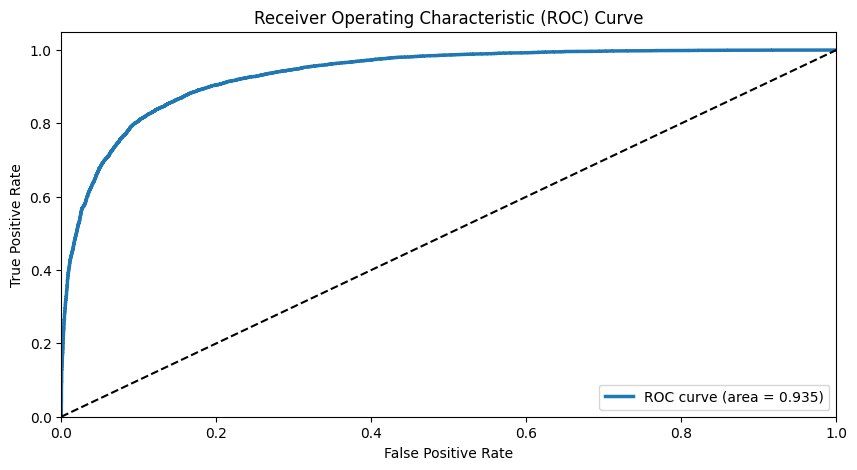

In [302]:
# 2.2 Random Forest with STEMM normalization and Bow

X_train_norm = X_train_norm_stemm
X_test_norm = X_test_norm_stemm

# BoW
cv = CountVectorizer()                            
cv.fit(X_train_norm)
X_train_vect_bow = cv.transform(X_train_norm)
X_test_vect_bow = cv.transform(X_test_norm)


# RANDOM FOREST CLASIFFIER
rfr= RandomForestClassifier(n_jobs=-1, random_state=0)
rfr.set_params(**rfr_best_param)
rfr.fit(X_train_vect_bow, y_train)

# Predicting and evaluation metrics
model = rfr
features = X_test_vect_bow
roc_auc = evaluation.plot_roc(model, y_test, features)

# Saving roc_auc for plot
roc_auc_rf_stemm_bow = roc_auc

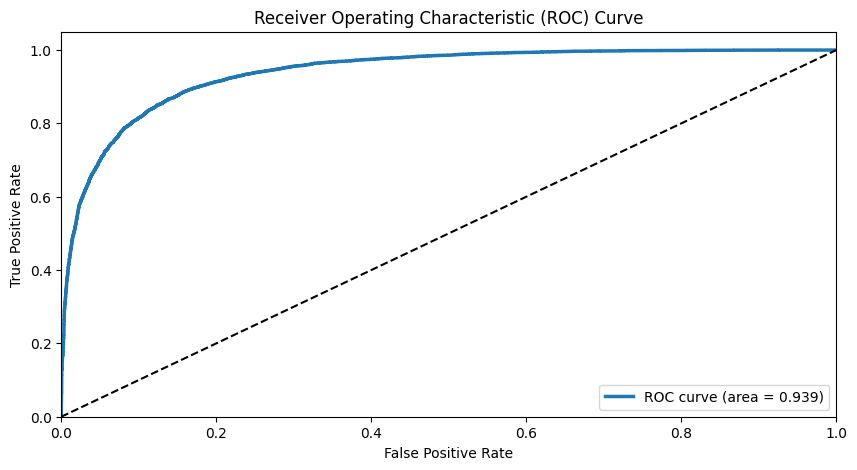

In [303]:
# 2.3 Random Forest without STEMM or LEMMA and BoW

X_train_norm = X_train_norm_without
X_test_norm = X_test_norm_without

# BoW
cv = CountVectorizer()                            
cv.fit(X_train_norm)
X_train_vect_bow = cv.transform(X_train_norm)
X_test_vect_bow = cv.transform(X_test_norm)


# RANDOM FOREST CLASIFFIER
rfr= RandomForestClassifier(n_jobs=-1, random_state=0)
rfr.set_params(**rfr_best_param)
rfr.fit(X_train_vect_bow, y_train)

# Predicting and evaluation metrics
model = rfr
features = X_test_vect_bow
roc_auc = evaluation.plot_roc(model, y_test, features)

# Saving roc_auc for plot
roc_auc_rf_without_bow = roc_auc

In [304]:
# Creating a df for plotting results 
roc_auc_rf_df=pd.DataFrame({
                'AUC_ROC' :[roc_auc_rf_without, roc_auc_rf_stem, roc_auc_rf_lemm,roc_auc_rf_without, roc_auc_rf_stemm_bow, roc_auc_rf_lemm_bow],
                'Vectorization' : ['TF-IDF', 'TF-IDF', 'TF-IDF', 'BoW', 'BoW', 'BoW'],
                'Normalization' : ['Without Stem or Lemma','With Stemm', 'With Lemma', 'Without Stem or Lemma','With Stemm', 'With Lemma'],     
                            })

In [305]:
roc_auc_rf_df

,AUC_ROC,Vectorization,Normalization
0,0.939,TF-IDF,Without Stem or Lemma
1,0.935,TF-IDF,With Stemm
2,0.938,TF-IDF,With Lemma
3,0.939,BoW,Without Stem or Lemma
4,0.935,BoW,With Stemm
5,0.938,BoW,With Lemma


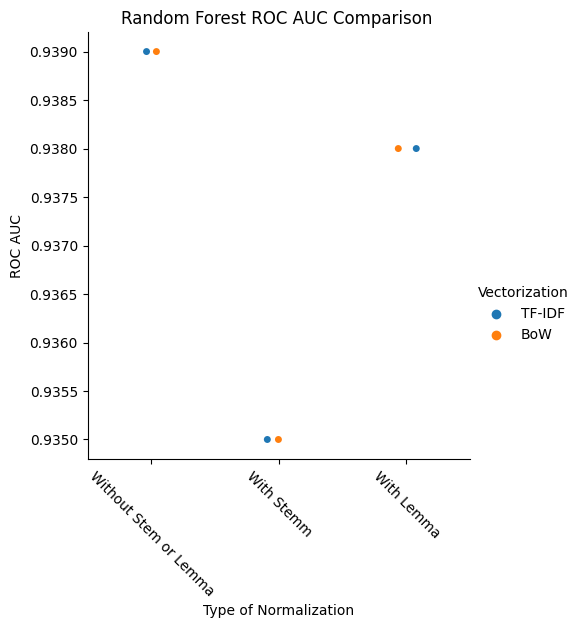

In [306]:
# Plotting the AUC_ROC results to compare the different models

ax=sns.catplot( data=roc_auc_rf_df, x ='Normalization', y = 'AUC_ROC', hue='Vectorization')
plt.title('Random Forest ROC AUC Comparison ')
ax.set_axis_labels('Type of Normalization','ROC AUC')
ax.set_xticklabels(rotation=-45)


### Normalization and Vectorization with RandomForest Clasiffier: Conclusions

Surprisingly, we can see in the plot above that the normalization of the corpus without Stemm or Lemmatization process obtains the best results (ROCAUC near 0.939), both with TF-IDF or BoW vectorizations.

Lemmatization obtains the second-best result, using TF-IDF or BoW, with ROC_AUC near 0.938. 

Finally, with stemm we obtain the lower result (ROCAUC near 0.935 using both TF-IDF and BoW)

### 3. LightGBM CLASSIFIER with TF-IDF

In [307]:
# 3.1 LightGBM CLASIFFIER without Lemma or Stemm and TDF-IDF

from lightgbm import LGBMClassifier

# Normalization
X_train_norm = X_train_norm_without
X_test_norm = X_test_norm_without

# TF - IDF
# Create an instance
vectorizer = TfidfVectorizer(norm = None)

# Generating output for TF_IDF, both for X_train (normalized) and X_test (normalized)
vectorizer.fit(X_train_norm) 
X_train_vect = vectorizer.transform(X_train_norm)
X_test_vect = vectorizer.transform(X_test_norm)

# LightGBM Clasiffier
lgbm = LGBMClassifier(objective='binary', random_state=5)
# Hyperparameters values of RandomForestClassifier

# Number of trees in the forest
n_estimators = [50,100,500]
# Maximum number of levels in tree
max_depth = [-1,20,50,100]
# Minimum number of samples required at each leaf node
min_child_samples = [1, 2, 4, 20, 40]
# Minimum number of samples required to split a node
min_split_gain = [0, 2, 5, 10]
# Number of features to consider at every split
learning_rate = [0.1, 0.01 , 0.001, 0.0001 ]

# Creating the dictionary of Hyperparameters
hyper_dict = { 'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_split_gain': min_split_gain,
               'min_child_samples': min_child_samples,
               'learning_rate': learning_rate,}

#Crating an instance of RandomizedSearchCV
#Params:
# n_iter: Number of parameter settings that are sampled. controls how many of combinations of hiperparameters to try
# cv: Determines the cross-validation splitting strategy

lgbm_randomCV = RandomizedSearchCV(lgbm, hyper_dict,  n_iter=10, cv=5, random_state=123, scoring="roc_auc")
lgbm_randomCV.fit(X_train_vect, y_train)

# # Predicting and evaluation metrics
predict_proba_LGBM=lgbm_randomCV.predict_proba(X_test_vect)
one_probability_LGBM=predict_proba_LGBM[:,1]

# Saving roc_auc for plot
LGBM_roc_auc_tfidf_without =round(roc_auc_score(y_test, one_probability_LGBM),3)
LGBM_roc_auc_tfidf_without

0.946

In [308]:
# Getting the best parameters for RandomForestClassifier
lgbm_best_param=lgbm_randomCV.best_params_
lgbm_best_param

{'n_estimators': 500,
 'min_split_gain': 2,
 'min_child_samples': 20,
 'max_depth': 50,
 'learning_rate': 0.1}

In [309]:
# 3.2 LightGBM CLASIFFIER with Lemma normalization and TDF-IDF

# Normalization
X_train_norm = X_train_norm_lemmatized
X_test_norm = X_test_norm_lemmatized

# TF - IDF
# Create an instance
vectorizer = TfidfVectorizer(norm = None)

# Generating output for TF_IDF, both for X_train (normalized) and X_test (normalized)
vectorizer.fit(X_train_norm) 
X_train_vect = vectorizer.transform(X_train_norm)
X_test_vect = vectorizer.transform(X_test_norm)

# LightGBM Clasiffier
lgbm= LGBMClassifier(objective='binary', random_state=5)
lgbm.set_params(**lgbm_best_param)
lgbm.fit(X_train_vect, y_train)

# # Predicting and evaluation metrics
predict_proba_LGBM=lgbm.predict_proba(X_test_vect)
one_probability_LGBM=predict_proba_LGBM[:,1]

# Saving roc_auc for plot
LGBM_roc_auc_tfidf_lemma =round(roc_auc_score(y_test, one_probability_LGBM),3)
LGBM_roc_auc_tfidf_lemma

0.946

In [310]:
# 3.2 LightGBM CLASIFFIER with Stemm normalization and TDF-IDF

# Normalization
X_train_norm = X_train_norm_stemm
X_test_norm = X_test_norm_stemm

# TF - IDF
# Create an instance
vectorizer = TfidfVectorizer(norm = None)

# Generating output for TF_IDF, both for X_train (normalized) and X_test (normalized)
vectorizer.fit(X_train_norm) 
X_train_vect = vectorizer.transform(X_train_norm)
X_test_vect = vectorizer.transform(X_test_norm)

# LightGBM Clasiffier
lgbm= LGBMClassifier(objective='binary', random_state=5)
lgbm.set_params(**lgbm_best_param)
lgbm.fit(X_train_vect, y_train)

# # Predicting and evaluation metrics
predict_proba_LGBM=lgbm.predict_proba(X_test_vect)
one_probability_LGBM=predict_proba_LGBM[:,1]

# Saving roc_auc for plot
LGBM_roc_auc_tfidf_stemm =round(roc_auc_score(y_test, one_probability_LGBM),3)
LGBM_roc_auc_tfidf_stemm

0.944

### 4. LightGBM CLASIFFIER with BoW

In [311]:
# 4.1 LightGBM CLASIFFIER without Lemma or Stemm and BoW

# Normalization
X_train_norm = X_train_norm_without
X_test_norm = X_test_norm_without

# BoW
cv = CountVectorizer(dtype= np.float64 )                            
cv.fit(X_train_norm)
X_train_vect_bow = cv.transform(X_train_norm)
X_test_vect_bow = cv.transform(X_test_norm)

# LightGBM Clasiffier
lgbm= LGBMClassifier(objective='binary', random_state=5)
lgbm.set_params(**lgbm_best_param)
lgbm.fit(X_train_vect_bow, y_train)

# # Predicting and evaluation metrics
predict_proba_LGBM=lgbm.predict_proba(X_test_vect_bow)
one_probability_LGBM=predict_proba_LGBM[:,1]

# Saving roc_auc for plot
LGBM_roc_auc_bow_without =round(roc_auc_score(y_test, one_probability_LGBM),3)
LGBM_roc_auc_bow_without

0.946

In [312]:
# 4.2 LightGBM CLASIFFIER with Lemma and BoW

# Normalization
X_train_norm = X_train_norm_lemmatized
X_test_norm = X_test_norm_lemmatized

# BoW
cv = CountVectorizer(dtype= np.float64 )                            
cv.fit(X_train_norm)
X_train_vect_bow = cv.transform(X_train_norm)
X_test_vect_bow = cv.transform(X_test_norm)

# LightGBM Clasiffier
lgbm= LGBMClassifier(objective='binary', random_state=5)
lgbm.set_params(**lgbm_best_param)
lgbm.fit(X_train_vect_bow, y_train)

# # Predicting and evaluation metrics
predict_proba_LGBM=lgbm.predict_proba(X_test_vect_bow)
one_probability_LGBM=predict_proba_LGBM[:,1]

# Saving roc_auc for plot
LGBM_roc_auc_bow_lemma =round(roc_auc_score(y_test, one_probability_LGBM),3)
LGBM_roc_auc_bow_lemma

0.946

In [313]:
# 4.2 LightGBM CLASIFFIER with Stemm and BoW

# Normalization
X_train_norm = X_train_norm_stemm
X_test_norm = X_test_norm_stemm

# BoW
cv = CountVectorizer(dtype= np.float64 )                            
cv.fit(X_train_norm)
X_train_vect_bow = cv.transform(X_train_norm)
X_test_vect_bow = cv.transform(X_test_norm)

# LightGBM Clasiffier
lgbm= LGBMClassifier(objective='binary', random_state=5)
lgbm.set_params(**lgbm_best_param)
lgbm.fit(X_train_vect_bow, y_train)

# # Predicting and evaluation metrics
predict_proba_LGBM=lgbm.predict_proba(X_test_vect_bow)
one_probability_LGBM=predict_proba_LGBM[:,1]

# Saving roc_auc for plot
LGBM_roc_auc_bow_stemm=round(roc_auc_score(y_test, one_probability_LGBM),3)
LGBM_roc_auc_bow_stemm

0.944

In [314]:
# Creating a df for plotting results 
roc_auc_lgbm_df=pd.DataFrame({
                'AUC_ROC' :[LGBM_roc_auc_tfidf_without,LGBM_roc_auc_tfidf_stemm, LGBM_roc_auc_tfidf_lemma,LGBM_roc_auc_bow_without, LGBM_roc_auc_bow_stemm, LGBM_roc_auc_bow_lemma],
                'Vectorization' : ['TF-IDF', 'TF-IDF', 'TF-IDF', 'BoW', 'BoW', 'BoW'],
                'Normalization' : ['Without Stem or Lemma','With Stemm', 'With Lemma', 'Without Stem or Lemma','With Stemm', 'With Lemma'],     
                            })

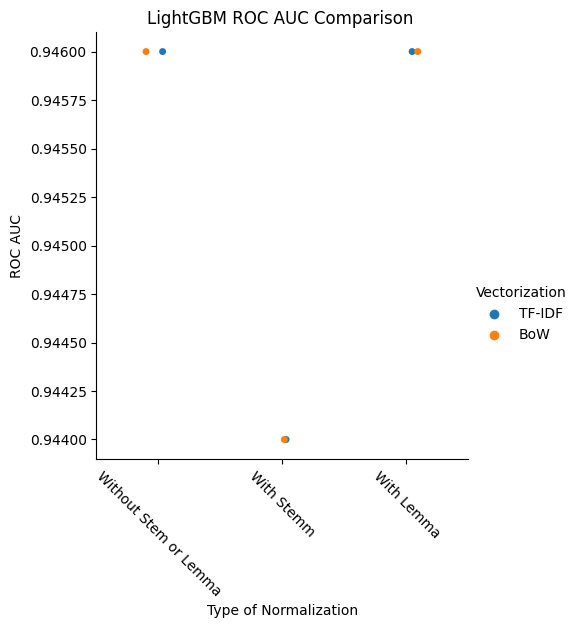

In [315]:
# Plotting the AUC_ROC results to compare the different models

ax=sns.catplot( data=roc_auc_lgbm_df, x ='Normalization', y = 'AUC_ROC', hue='Vectorization')
plt.title('LightGBM ROC AUC Comparison ')
ax.set_axis_labels('Type of Normalization','ROC AUC')
ax.set_xticklabels(rotation=-45)

### Normalization and Vectorization with LightGBM Clasiffier: Conclusions

Firstly, we can say that in the same conditions, LighGBM improves results compare to RandomForest Classifier, about 1%, and besides LightGBM is faster.

We can see in the plot above that the normalization of the corpus without Stemm or Lemmatization, and the normalization with Lemmatization obtain the same results (ROCAUC near 0.946), both with TF-IDF or BoW vectorizations.

With stemm we obtain the lower result (ROCAUC near 0.944 using both TF-IDF and BoW).

So, we are in conditions to say that the best combinations between Normalizing, vectorizing and classification are:

    * LightGBM 
    * Without Stemm or Lemma, or with Lemma
    * Using both IF-TDF or BoW


---
## 5. Feature Engineering with Custom Word Embedding

### Training our own Word Embedding


In [316]:
# Using Normalized corpus

X_train_norm = X_train_norm_lemmatized
X_test_norm = X_test_norm_lemmatized

In [317]:
# Tokenization of X_train_norm
tokenizer = ToktokTokenizer()
X_train_tokenized_corpus = [tokenizer.tokenize(reviews) for reviews in X_train_norm]

In [318]:
# Tokenization of X_test_norm
X_test_tokenized_corpus = [tokenizer.tokenize(reviews) for reviews in X_test_norm]

In [319]:
#Training the model
model_w2v = Word2Vec(sentences = X_train_tokenized_corpus, vector_size=100, window=20, min_count=2, epochs = 25, seed =124, max_final_vocab=20000,  workers=4)

In [320]:
# Looking for the results of the model training
model_w2v.wv.vectors.shape

(18613, 100)

### Generate averaged word vector features

Once the embedding has been trained, we must use it. Embedding will convert each word you pass to it into a vector of a given dimension (in our case $vector\_size=100$). So in order to obtain a vector for each review, we must average the vectors of all the words that are part of the same review.

The function must have the following form:
* `vectorizer(corpus, model, num_features=100)`


Where:
* `corpus:` corresponds to the entire dataset, in this way we obtain an average vector for each review, with a single call to the function.
* `model:` is your trained model.
* `num_features:` the dimension of the output vector of your embedding (remember that in our case we set this value to 100).

In [321]:
def vectorizer(corpus, model, num_features=100):
    # Put your code

    corpus_vectors =[]
    total_words = model.wv
    
    for review in corpus:
        #Creating zero vector
        sum_vect=[ 0 for x in range(num_features)]
        # For every review in corpus, we check if the word exists. 
        # if exists, we make the average along all the review vectors
        for word in review:
            if word in total_words:
                word_vector = model.wv[word]
                sum_vect += word_vector
        av_vector = sum_vect / len(review)
        corpus_vectors.append(av_vector)
        
    return corpus_vectors

### Test 3


In [322]:
def check_embedding(model):
    vector = model.wv['computer']
    if len(vector) == 100:
        print(
            'Success! Your embedding tells me that "women" and "man" '
            f'are similar with a score of {model.wv.similarity("woman", "man")}'
        )
    else:
        raise ValueError('You should check your embedding vector size!')
        
check_embedding(model_w2v)

Success! Your embedding tells me that "women" and "man" are similar with a score of 0.5730818510055542


Now, we are going to check the vectorizer, remember that the vectorizer must generate an average vector of all the words present in the same review. So we're going to get two vectors of two words and manually average them, then using those two words we'll simulate a tokenized sentence and see that it matches the manual way.

In [323]:
def check_vectorizer(model):
    vector1 = model.wv['personal']
    vector2 = model.wv['computer']
    avg = vectorizer([['personal', 'computer']], model)[0]

    if np.allclose((vector1 + vector2) / 2, avg):
        print('Success!')
    else:
        raise ValueError('You should check your vectorizer!')
        
check_vectorizer(model_w2v)

Success!


### Modeling

Finally train a new model, it can be the same one you used before and compare the results you got using BoW/TF-IDF and Word2Vec.

In addition to training the model we ask you to show:

* `Accuracy`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`
* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

In [324]:

# Vectorize the train set with w2v
X_train_vect_cwe= vectorizer (X_train_tokenized_corpus, model_w2v)

#### RANDOM FOREST CLASSIFIER

We'll make the first experiment with a RF Classifier and check results

In [325]:
# Training RANDOM FOREST CLASIFFIER

rf_cwe= RandomForestClassifier(n_jobs=-1)
rf_cwe.set_params(**rfr_best_param)
rf_cwe.fit(X_train_vect_cwe, y_train)


RandomForestClassifier(max_depth=50, max_features='auto', min_samples_split=5,
                       n_estimators=500, n_jobs=-1)

In [326]:
# Using the model to vectorize the TEST set
X_test_vect_cwe= vectorizer (X_test_tokenized_corpus, model_w2v)

In [327]:
# PREDICTION AND METRICS

# Using the RF Clasiffier to predict 
predict_rf_cwe=rf_cwe.predict(X_test_vect_cwe)

# Getting metrics
evaluation.get_performance(predict_rf_cwe, y_test)

Model Performance metrics:
------------------------------
Accuracy: 0.82
Precision: 0.82
Recall: 0.82
F1 Score: 0.82

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.82      0.81      0.82     12500
           0       0.82      0.82      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10165   2335
1   2195  10305


(0.82, 0.82, 0.82, 0.82)

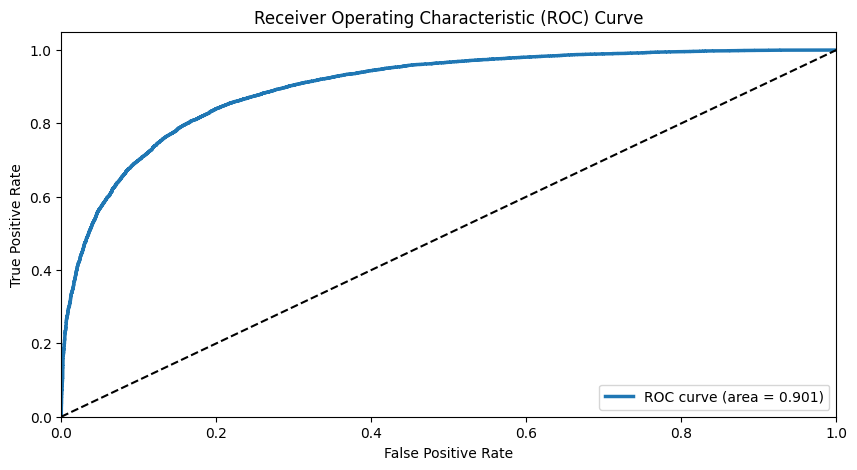

In [328]:
model = rf_cwe
features = X_test_vect_cwe
roc_auc_cwe = evaluation.plot_roc(model, y_test, features)

We can see that the ROC_AUC is under the requirements of 0.93

So, we'll try with another Classifier

#### LightGBM CLASSIFIER



In [329]:
# 2. LightGBM CLASIFFIER 

# Normalization without Lemma or Stemm 
X_train_norm = X_train_norm_without
X_test_norm = X_test_norm_without

# Tokenization of X_train_norm
tokenizer = ToktokTokenizer()
X_train_tokenized_corpus = [tokenizer.tokenize(reviews) for reviews in X_train_norm]

#Training the model
model_w2v = Word2Vec(sentences = X_train_tokenized_corpus, vector_size=100, window=20, min_count=2, epochs = 20, seed =124, max_final_vocab=20000,  workers=4)

# Vectorize the train set with w2v
X_train_vect_cwe= vectorizer (X_train_tokenized_corpus, model_w2v)

# LightGBM Clasiffier
lgbm = LGBMClassifier(objective='binary', random_state=5)
lgbm.set_params(**lgbm_best_param)
lgbm.fit(X_train_vect_cwe, y_train)

# 6. Using the model to vectorize the TEST set
X_test_tokenized_corpus = [tokenizer.tokenize(reviews) for reviews in X_test_norm]
X_test_vect_cwe= vectorizer (X_test_tokenized_corpus, model_w2v)

# # Predicting and evaluation metrics
predict_proba_LGBM=lgbm.predict_proba(X_test_vect_cwe)
one_probability_LGBM=predict_proba_LGBM[:,1]

# Saving roc_auc for plot
LGBM_roc_auc_w2v_cwe =round(roc_auc_score(y_test, one_probability_LGBM),3)
LGBM_roc_auc_w2v_cwe

0.932

### *Test 4*

In [330]:
check_roc(LGBM_roc_auc_w2v_cwe)

Success!


---
### We'll train a word embedding from scratch:

Firstly, I'll use wikipedia pre-trained model with vector_size=100

In [331]:
import gensim.downloader as api

# Download embeddings (trained on wikipedia)
# Using the same size of vectorization to compare with point 5
model_ptr_wiki1 = api.load("glove-wiki-gigaword-100")


In [332]:
model_ptr_wiki1.vectors.shape

(400000, 100)

So we have 400.000 words of vocabulary and each word has an embedding of size = 100

In [346]:
# Same as "vectorizer" function but only with a little change, removing "wv" on "model.wv".

def vectorizer2(corpus, model, num_features=100):
    # Put your code
    corpus_vectors =[]
    total_words = model
    for review in corpus:
        sum_vect=[ 0 for x in range(num_features)]
        for word in review:
            if word in total_words:
                word_vector = model[word]
                sum_vect += word_vector
        av_vector = sum_vect / len(review)
        corpus_vectors.append(av_vector)
            
    return corpus_vectors

In [334]:
# Normalization without Lemma or Stemm 
X_train_norm = X_train_norm_without
X_test_norm = X_test_norm_without

# Tokenization of X_train_norm
tokenizer = ToktokTokenizer()
X_train_tokenized_corpus = [tokenizer.tokenize(reviews) for reviews in X_train_norm]


# Vectorize the train set with w2v
X_train_vect_ptr= vectorizer2 (X_train_tokenized_corpus, model_ptr)

# LightGBM Clasiffier
lgbm_ptr = LGBMClassifier(objective='binary', random_state=5)
lgbm_ptr.set_params(**lgbm_best_param)
lgbm_ptr.fit(X_train_vect_ptr, y_train)

# 6. Using the model to vectorize the TEST set
X_test_tokenized_corpus = [tokenizer.tokenize(reviews) for reviews in X_test_norm]
X_test_vect_ptr= vectorizer2(X_test_tokenized_corpus, model_ptr)

# # Predicting and evaluation metrics
predict_proba_LGBM=lgbm_ptr.predict_proba(X_test_vect_ptr)
one_probability_LGBM=predict_proba_LGBM[:,1]

# Saving roc_auc for plot
LGBM_roc_auc_ptr_wiki1 =round(roc_auc_score(y_test, one_probability_LGBM),3)
LGBM_roc_auc_ptr_wiki1

0.876

Secondly, I'll use wikipedia pre-trained model with vector_size=300

In [335]:
import gensim.downloader as api

# Download embeddings (trained on wikipedia)
# Using the same size of vectorization to compare with point 5
model_ptr_wiki3 = api.load("glove-wiki-gigaword-300")

In [336]:
model_ptr_wiki3.vectors.shape

(400000, 300)

In [337]:
# Normalization without Lemma or Stemm 
X_train_norm = X_train_norm_without
X_test_norm = X_test_norm_without

# Tokenization of X_train_norm
tokenizer = ToktokTokenizer()
X_train_tokenized_corpus = [tokenizer.tokenize(reviews) for reviews in X_train_norm]

# Vectorize the train set with w2v
X_train_vect_ptr= vectorizer2 (X_train_tokenized_corpus, model_ptr_wiki3, num_features = 300 )

# LightGBM Clasiffier
lgbm_ptr = LGBMClassifier(objective='binary', random_state=5)
lgbm_ptr.set_params(**lgbm_best_param)
lgbm_ptr.fit(X_train_vect_ptr, y_train)

# 6. Using the model to vectorize the TEST set
X_test_tokenized_corpus = [tokenizer.tokenize(reviews) for reviews in X_test_norm]
X_test_vect_ptr= vectorizer2(X_test_tokenized_corpus, model_ptr_wiki3, num_features = 300)

# # Predicting and evaluation metrics
predict_proba_LGBM=lgbm_ptr.predict_proba(X_test_vect_ptr)
one_probability_LGBM=predict_proba_LGBM[:,1]

# Saving roc_auc for plot
LGBM_roc_auc_ptr_wiki3 =round(roc_auc_score(y_test, one_probability_LGBM),3)
LGBM_roc_auc_ptr_wiki3

0.907

Now, I'll use Twitter pre-trained models

In [338]:

# Download embeddings 
# Using the same size of vectorization to compare with point 5
model_ptr_tw = api.load("glove-twitter-100")

In [339]:
model_ptr_tw.vectors.shape

(1193514, 100)

So we have almost 1.200.000 words of vocabulary and each word has an embedding of size = 100

In [340]:
# Normalization without Lemma or Stemm 
X_train_norm = X_train_norm_without
X_test_norm = X_test_norm_without

# Tokenization of X_train_norm
tokenizer = ToktokTokenizer()
X_train_tokenized_corpus = [tokenizer.tokenize(reviews) for reviews in X_train_norm]

# Vectorize the train set with w2v
X_train_vect_ptr= vectorizer2 (X_train_tokenized_corpus, model_ptr_tw)

# LightGBM Clasiffier
lgbm_ptr = LGBMClassifier(objective='binary', random_state=5)
lgbm_ptr.set_params(**lgbm_best_param)
lgbm_ptr.fit(X_train_vect_ptr, y_train)

# 6. Using the model to vectorize the TEST set
X_test_tokenized_corpus = [tokenizer.tokenize(reviews) for reviews in X_test_norm]
X_test_vect_ptr= vectorizer2(X_test_tokenized_corpus, model_ptr_tw)

# # Predicting and evaluation metrics
predict_proba_LGBM=lgbm_ptr.predict_proba(X_test_vect_ptr)
one_probability_LGBM=predict_proba_LGBM[:,1]

# Saving roc_auc for plot
LGBM_roc_auc_w2v_ptr_tw =round(roc_auc_score(y_test, one_probability_LGBM),3)
LGBM_roc_auc_w2v_ptr_tw

0.885

Now, I'll use the same twitter pre-trained model but with vector_size = 200

In [341]:

# Download embeddings 
# Using the same size of vectorization to compare with point 5
model_ptr_tw2 = api.load("glove-twitter-200")

In [342]:
model_ptr_tw2.vectors.shape

(1193514, 200)

In [343]:
# Normalization without Lemma or Stemm 
X_train_norm = X_train_norm_without
X_test_norm = X_test_norm_without

# Tokenization of X_train_norm
tokenizer = ToktokTokenizer()
X_train_tokenized_corpus = [tokenizer.tokenize(reviews) for reviews in X_train_norm]

# Vectorize the train set with w2v
X_train_vect_ptr= vectorizer2 (X_train_tokenized_corpus, model_ptr_tw2, num_features = 200 )

# LightGBM Clasiffier
lgbm_ptr = LGBMClassifier(objective='binary', random_state=5)
lgbm_ptr.set_params(**lgbm_best_param)
lgbm_ptr.fit(X_train_vect_ptr, y_train)

# 6. Using the model to vectorize the TEST set
X_test_tokenized_corpus = [tokenizer.tokenize(reviews) for reviews in X_test_norm]
X_test_vect_ptr= vectorizer2(X_test_tokenized_corpus, model_ptr_tw2, num_features = 200)

# # Predicting and evaluation metrics
predict_proba_LGBM=lgbm_ptr.predict_proba(X_test_vect_ptr)
one_probability_LGBM=predict_proba_LGBM[:,1]

# Saving roc_auc for plot
LGBM_roc_auc_w2v_ptr_tw2 =round(roc_auc_score(y_test, one_probability_LGBM),3)
LGBM_roc_auc_w2v_ptr_tw2

0.903

In [344]:
# Creating a df for plotting results 
roc_auc_ptr_df=pd.DataFrame({
                'AUC_ROC' :[LGBM_roc_auc_ptr_wiki1,LGBM_roc_auc_ptr_wiki3, LGBM_roc_auc_w2v_ptr_tw,LGBM_roc_auc_w2v_ptr_tw2],
                'Embedding' : ['Wiki100', 'Wiki300', 'Twitter100', 'Twitter200'],
                            })

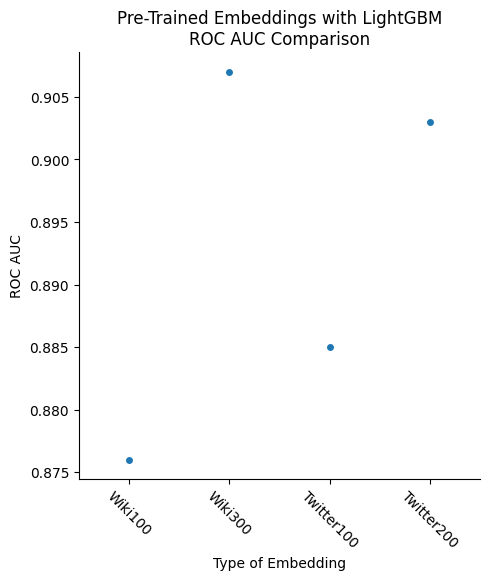

In [345]:
# Plotting the AUC_ROC results to compare the different models

ax=sns.catplot( data=roc_auc_ptr_df, x ='Embedding', y = 'AUC_ROC')
plt.title('Pre-Trained Embeddings with LightGBM' '\n' 'ROC AUC Comparison')
ax.set_axis_labels('Type of Embedding','ROC AUC')
ax.set_xticklabels(rotation=-45)

Pre-trained embeddings: Conclusions

We used two types of pre-trained embeddings: Wikipedia and Twitter, with different vectors size.

Wiki embedding has a vocabulary of 400.000 words, while Twitter embedding has 1.200.000

Evaluating the results, we see that Wiki 300 has obtained the best result using the third part of Twitter embedding.

Nevertheless, we couldn't obtain w2v trained by myself.

